In [9]:
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.models.particle_pair import Particle_Pair
from ATARI.models.experimental_model import Experimental_Model
from ATARI.models.generative_models import Generative_Model


In [10]:
%matplotlib widget

# Define generative models

Neutron induced reaction measurements using the time-of-flight method can be modelled using 3 primary categories:
1. A reaction model, represented here in ATARI the Particle_Pair class
2. An experimental model, represented here in ATARI by the Experimental_Model class
3. A reduction model, represented in ATARI by a Reduction_Model protocol

These three models attempt to describe everything that is happenning in one of these experiments. 
Traditionally, these models are used to analyze experimental data. 
The Syndat module of the ATARI code uses these models in a generative manner, producing statistical samples of experimental data.

The Generative_Model class is a container for the above three models that will be used to generate data.
This class can be instantiated with defaults, or each of the respective models can be supplied individually.
The following code snippet shows how these models can be created and manipulated from the defaults in the Generative Model container.

In [11]:
# take default values and inspect each

generative_model_1 = Generative_Model()

print("Particle Pair Model:\n")
print(generative_model_1.particle_pair)

print()
print("Experimental Model Sammy Inputs:")
print(generative_model_1.experimental_model.sammy_inputs)

print()
print("Experimental Model Sammy Inputs Altered:")
generative_model_1.experimental_model.sammy_inputs = {'alphanumeric': ["BROADENING IS NOT WANTED"],
                                                      'ResFunc' : ''}
print(generative_model_1.experimental_model.sammy_inputs)


print()
print("Reduction Model:")
print(generative_model_1._reduction_model)

Particle Pair Model:

I: 3.5
M: 180.94803
ac: 8.127
formalism: XCT
i: 0.5
isotope: Ta181
l_max: 2
m: 1
resonance_ladder: Empty DataFrame
Columns: []
Index: []
spin_groups: {}


Experimental Model Sammy Inputs:
{'alphanumeric': ['BROADENING IS WANTED', 'DO NOT SHIFT RPI RESOLUTION'], 'ResFunc': 'RPI T'}

Experimental Model Sammy Inputs Altered:
{'alphanumeric': ['BROADENING IS NOT WANTED'], 'ResFunc': ''}

Reduction Model:


## Reaction Model: Particle Pair class
Each of the 3 models can also be created outside and then added to the Generative Model container.
These ATARI classes have additional functionality if you want to work with them at this lower level.
The following code snippet demonstrates some of these capabilities.

In [12]:
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        ac = 8.127,
                        M = 180.94803,
                        I = 3,
                        l_max = 2
)

# print quant number map up to l_max
Ta_pair.map_quantum_numbers(print_out=True)

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)
Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

print()
print("Interrogate spin group attribute:")
print(Ta_pair.spin_groups['3.0'])


print()
print("Resonance ladder sampled from resonance statistics:")
print(Ta_pair.sample_resonance_ladder(energy_range=[200, 250]))

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-4.5, 1, [1])
(-3.5, 2, [1, 1])
(-2.5, 2, [1, 1])
(-1.5, 1, [1])
(0.5, 1, [2])
(1.5, 2, [2, 2])
(2.5, 3, [0, 2, 2])
(3.5, 3, [0, 2, 2])
(4.5, 2, [2, 2])
(5.5, 1, [2])

Interrogate spin group attribute:
{'J_ID': 1, '<D>': 8.79, '<Gn>': 46.5, 'n_dof': 1, '<Gg>': 64.0, 'g_dof': 1000, 'D01': 0.9943384234177864, 'D99': 21.284662911191237, 'Gn01': 0.007304585392801135, 'Gn99': 308.52269194748646, 'Gg01': 57.53039660349525, 'Gg99': 70.84601563854191, 'Gt01': 57.53770118888805, 'Gt99': 379.3687075860284}

Resonance ladder sampled from resonance statistics:
             E         Gg         Gn1    J J_ID varyE varyGg varyGn1
0   202.038355  67.824571  163.703172  3.0    1   0.0    0.0     0.0
1   206.364352   68.61328    12.64146  3.0    1   0.0    0.0     0.0
2   220.941666  64.749167    5.399072  3.0    1   0.0    0.0     0.0
3   231.071068  63.000174  209.207036  3.0    1   0.0    0.0     0.0
4   236.896191  66.661672      9.4369  3.0    1

## Experimental Model class & Sammy

This class's primary purpose is to hold relevant experimental information used in calculating experimentally corrected resonance models with SAMMY.
The ATARI code come with a sammy-interface module that wraps around the sammy code. For more details on this interface, see the user example notebook. 
Before the Experimental_Model can be passed to syndat, the user must define the template parameter to be a path to a sammy input template. 

The sammy interface has a module for creating template input files from these generative models. 
The idea is that you make the template, inspect it manually, then give it to the experimental model class to be used with syndat

In [13]:

exp_trans12 = Experimental_Model(title = "T12mm", 
                                 reaction = "transmission", 
                                 energy_range = [200, 250], 
                                 template = None, 
                                 energy_grid = None, 
                                 n = (0.067166, 0.0), 
                                 FP = (35.185, 0.0), 
                                 t0 = (3326.0, 0.0), 
                                 burst = (10, 1.0), 
                                 temp = (300, 0.0), 
                                 channel_widths = { 
                                     "maxE": [200],
                                     "chw": [100.0],
                                     "dchw": [0.8]
                                 }
)


sammy_rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template(
    'template_T.inp', Ta_pair, exp_trans12, sammy_rto)

In [14]:

# 'n'         :   (0.067166,            0),
# 'FP'        :   (35.185,              0),
# 't0'        :   (3.326,               0),
# 'bw'        :   (0.0064,              0),

# exp_model_Y = experimental_model("Y1mm", "capture", [200,250],
                               
#                                     parameters={
#                                         'FP':(100.14,0.01),
#                                         't0':(2.0, 0.0)
#                                         } ,

#                                     channel_width_info={
#                                           "maxE": [500], 
#                                           "chw": [100.0],
#                                           "dchw": [0.8]
#                                           }
#                                                                   )

# exp_model_Y

# Calculate theoretical with sammy

In [15]:
# calculate experimentally corrected transmission or capture yield with sammy

importlib.reload(template_creator)
importlib.reload(sammy_functions)

rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True,
                              "sammy_runDIR": "sammy_runDIR_1"
                              })

template_creator.make_input_template('template_T.inp', Ta_pair, exp_model_T, rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, exp_model_Y, rto)


NameError: name 'exp_model_T' is not defined

In [16]:

datasets = [exp_model_T.energy_grid, exp_model_Y.energy_grid] 
experiments= [exp_model_T, exp_model_Y] 

templates = [os.path.realpath('template_T.inp'),os.path.realpath('template_Y.inp')]

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,  

    datasets= datasets,
    templates= templates,
    experiments = experiments,
    )

sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)


NameError: name 'exp_model_T' is not defined

In [17]:
### define a dataframes to hold the true value with column key 'true' 

true_dfs = []
for i, exp in enumerate(experiments):
    true_df = copy(sammyOUT.pw[i])
    if exp.reaction == "transmission":
        true = "theo_trans"
    elif exp.reaction == "capture":
        true = "theo_xs"
    else:
        raise ValueError()

    assert(isinstance(true_df, pd.DataFrame))
    true_df = true_df[["E",true]]
    true_df.rename(columns={true:"true"}, inplace=True)

    true_dfs.append(true_df)


NameError: name 'experiments' is not defined

In [18]:
# o = np.linspace(1000, 1100, 1000)
# do = np.sqrt(o)

# T = np.linspace(0,1, 1000)
# s = np.log(T*o)
# ds = np.sqrt(s)

# # dT = np.sqrt( (1/o * ds)**2 + ((s/o**2)*do)**2)
# dT = np.sqrt()


# figure()

# # plot(T,np.sqrt(T)/20, label='sqrt(T)')
# # plot(o,do)
# plot(T,s)
# plot(T,dT, label="dT")
# # plot(synT.data.exp, synT.data.exp_unc, '.')
# # plot(synT.data.true, synT.data.exp_unc, '.')

# # plot(synT.raw_data.c, synT.data.exp, '.')
# # plot(synT.neutron_spectrum.dc, synT.data.exp, '.')

# # plot(synT.data.exp, np.sqrt(synT.data.exp))

# legend()

# Run Syndat experiment for each dataset

In [19]:

### pass true dataframe to syndat 

from ATARI.models.T_reduction_rpi import transmission_rpi
from ATARI.models.Y_reduction_rpi import yield_rpi
from syndat.old.control import syndat

generation_T1 = transmission_rpi()
reduction_T1 = transmission_rpi()

synT = syndat(options={})
synT.run(true_dfs[0], generation_T1, reduction_T1, exp_model_T)


# generation_C1 = yield_rpi()
# reduction_C1 = yield_rpi()

# synY = syndat(options={})
# synY.run(true_dfs[1], generation_C1, reduction_C1, exp_model_Y)

ModuleNotFoundError: No module named 'syndat'

In [20]:
# from ATARI.syndat.general_functions import neutron_background_function


# figure()

# plot(np.linspace(0, 1000, 10000), neutron_background_function(np.linspace(0, 1000, 10000),
#      generation_T1.reduction_parameters["a_b"][0][0], generation_T1.reduction_parameters["a_b"][0][1]))
# xscale('log')

NameError: name 'synT' is not defined

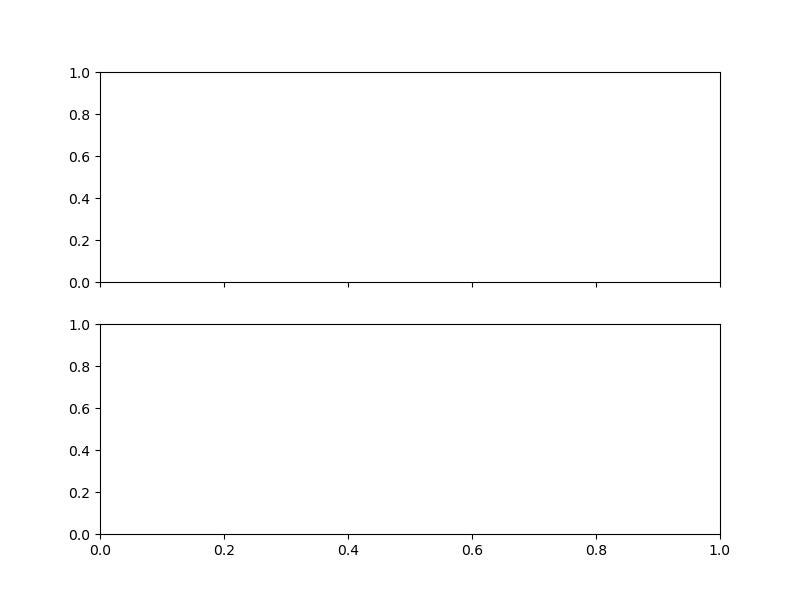

In [21]:
### Plot 

fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

### Trans
axes[0].errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

axes[0].plot(synT.data.E, synT.data.true)
axes[0].set_ylabel("T")

# ### Capture
# axes[1].errorbar(synY.data.E, synY.data.exp, yerr=synY.data.exp_unc, zorder=0, 
#                                         fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='1mm')
# axes[1].plot(synY.data.E, synY.data.true)

# axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,250])
    ax.set_ylim([-0.1,1.1])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

In [22]:
# rel_unc = synT.data.exp_unc/synT.data.exp
# figure()
# _ = hist(rel_unc)

## Syndat class

Options:
1. starting from real data or not
2. measurement type (capture, transmission)
3. Sampling options
4. reduction parameters

### Notes
resolution function parameters need not be sampled if true uncertainty because the uncertainty is represented by the experimental model (resolution function) if the parameters were sampled on the generative side then the resolution function would be different for the fit - this would be like testing USU

I'm not sure about n parameter, if this is uncertain, it should be sampled and uncertainty should be propagated in the data reduction - I think this value can be fited in sammy if it is uncertain

Need to add a 'true uncertainty' option:
1. if true: true_underlying_reduction_parameters will be sampled from same mean/std as given by reduction_parameters
2. if false: true_underlying_reduction_parameters will be samled from different mean/std than given by reduction_parameters

In [23]:

# class syndat:

#     def __init__(self, true: pd.DataFrame, experimental_model):
#         self.true = true
#         self.experimental_model = experimental_model

#         # maybe do some stuff about the energy gridding, maybe I dont need to supply true

#     def run(self, reduction_parameters = {}):


#         if self.experimental_model.reaction == "capture":
#             assert(np.isfinite(self.true.theo_xs))
#             # do capture


#         if self.experimental_model.reaction == "transmission":
#             assert(np.isfinite(self.true.theo_trans))
#             # do transmission



# Investigate Noise Distribution

In [26]:

# jb_df = pd.read_csv("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_reduction_data.csv", index_col='Unnamed: 0')
# jb_cov = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_cov.npy")
# jb_sys = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_syst.npy")
# jb_stat = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_stat.npy")
# jb_df['bw'] = jb_df.bw*1e-6
# realdat = jb_df.loc[(jb_df.e < 120) & (jb_df.e > 3)]


transdat12 = sammy_functions.readlst(
    "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
exptrans12 = Experimental_Model(title="trans12mm",
                                reaction="transmission",
                                energy_range=[2, 120],

                                sammy_inputs={
                                    'alphanumeric':   ["BROADENING IS WANTED"],
                                    'ResFunc':   "ORRES"
                                },

                                n= (0.067166, 0.0),
                                FP= (35.185, 0.0),
                                burst= (8, 0.0),
                                temp= (294.2610, 0.0),

                                channel_width_info={
                                    "maxE": [270],
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                },

                                additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000",
                                                          "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
                                )

transdat12 = transdat12[(transdat12.E < max(exptrans12.energy_range)) & (
    transdat12.E > min(exptrans12.energy_range))]

In [28]:
# from syndat.old.control import syndat
# from ATARI.models.Y_reduction_rpi import yield_rpi
# from ATARI.models.T_reduction_rpi import transmission_rpi

# fit from jeff


# sammyRTO = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
#                                              {"Print":   True,
#                                               "bayes":   False,
#                                               "keep_runDIR": False
#                                               })

# matnum = 7328
# jeff_file = "/Users/noahwalton/research_local/data/JEFF33_endf6/73-Ta-181g.jeff33"
# jeff_parameters = sammy_functions.get_endf_parameters(
#     jeff_file, matnum, sammyRTO)

# jeff_parameters = jeff_parameters[(
#     jeff_parameters.E < 120) & (jeff_parameters.E > 2)]
# jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))*1
# jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
# jeff_parameters["varyE"] = np.ones(len(jeff_parameters))*1


# datasets = [transdat12]
# experiments = [exptrans12]
# # templates = [os.path.realpath('template_T.inp')]
# templates = []
# for data, exp in zip(datasets, experiments):
#     filepath = f'template_{exp.title}'
#     # templates are already made and edited!
#     template_creator.make_input_template(filepath, model, exp, rto)
#     templates.append(os.path.realpath(filepath))

# sammyINPyw = sammy_classes.SammyInputDataYW(
#     particle_pair=Ta_pair,
#     model=model,
#     resonance_ladder=jeff_parameters,

#     datasets=datasets,
#     templates=templates,
#     experiments=experiments,

#     max_steps=20,
#     iterations=2,
#     step_threshold=0.01,
#     autoelim_threshold=None,

#     LS=False,
#     LevMar=True,
#     LevMarV=1.5,
#     # LevMarVd=5,
#     initial_parameter_uncertainty=0.1
# )

# sammyRTO.bayes = True
# sammyRTO.keep_runDIR = True
# sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

### Randomly sampled resonances ladders
Usually produces a similar signal to noise ratio unless the resonance ladder is drastically different, could look at average over many repetitions? Want to match 

In [29]:

sammyRTO = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                             {"Print":   True,
                                              "bayes":   False,
                                              "keep_runDIR": False
                                              })


datasets = [transdat12]
experiments = [exptrans12]
# templates = [os.path.realpath('template_T.inp')]
templates = []
for data, exp in zip(datasets, experiments):
    filepath = f'template_{exp.title}'
    template_creator.make_input_template(filepath, Ta_pair, exp, rto)
    templates.append(os.path.realpath(filepath))

res = Ta_pair.sample_resonance_ladder([2,120])

sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair=Ta_pair,
    resonance_ladder=res,

    datasets=datasets,
    templates=templates,
    experiments=experiments,
)

sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, sammyRTO)

In [30]:

true_df = copy(sammyOUT.pw[0])
assert (isinstance(true_df, pd.DataFrame))
true_df = true_df[["E", "theo_trans"]]
true_df.rename(columns={"theo_trans": "true"}, inplace=True)


generation_T1 = transmission_rpi(reduction_parameters={'trigo':   (9758727,             0),
                                                       'trigs':   (18476117,            0)}
                                                       )
reduction_T1 = transmission_rpi(reduction_parameters={'trigo':   (9758727,             0),
                                                      'trigs':   (18476117,            0)}
                                                      )

synT = syndat(options={})
synT.(true_df, generation_T1, reduction_T1, exp_model_T)

NameError: name 'syndat' is not defined

(-0.1, 1.0)

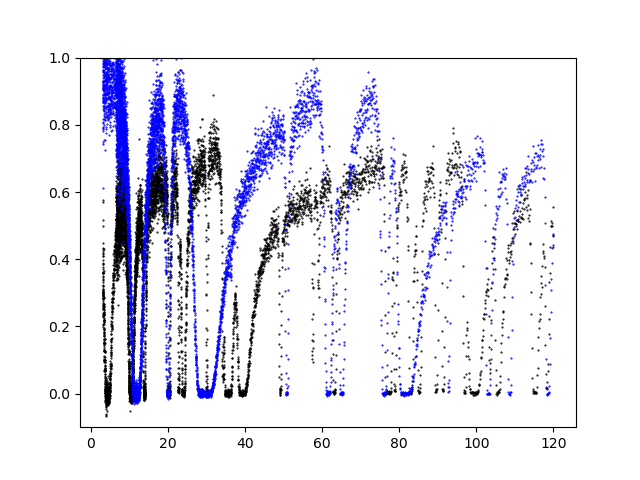

In [ ]:
figure()
plot(transdat12.E, transdat12.exp, 'k.', markersize=1)
plot(synT.data.E, synT.data.exp, 'b.', markersize=1)
# plot(synT.data.E, synT.data.true, 'b', markersize=1)
ylim([-0.1,1])

(0.0, 0.6714023436076302)

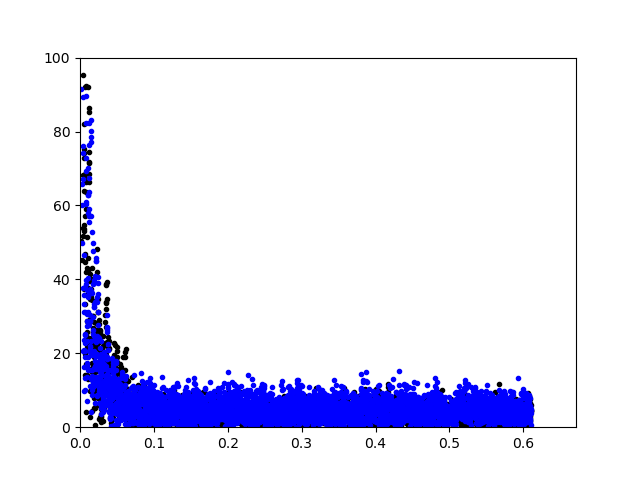

In [ ]:

freq = np.fft.fftfreq(len(synT.data.tof), synT.data.tof[1] - synT.data.tof[0])

Y = np.fft.fft(transdat12.exp)

Ysyn = np.fft.fft(synT.data.exp)
# P_signal = np.abs(Ysyn)**2
# P_noise = np.abs(Y[noise_indices])**2
# SNR = np.sum(P_signal) / np.sum(P_noise)

figure()
plot(freq, abs(Y), 'k.')
plot(freq, abs(Ysyn), 'b.')
ylim(-0.01, 100)
xlim(0)

# xscale('log')
# yscale('log')